In [ ]:
!pip install --upgrade git+https://github.com/yhilpisch/tpqoa.git

In [1]:
import os
import time
import numpy as np
import pandas as pd
from pprint import pprint
from pylab import plt, mpl
import tpqoa
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', '{:.5f}'.format)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

In [2]:
path = '/Users/dylanyap/working_file/'
api = tpqoa.tpqoa(path + 'crudential.cfg')
ins = api.get_instruments()
ins[:5]

[('AUD/CAD', 'AUD_CAD'),
 ('AUD/CHF', 'AUD_CHF'),
 ('AUD/HKD', 'AUD_HKD'),
 ('AUD/JPY', 'AUD_JPY'),
 ('AUD/NZD', 'AUD_NZD')]

In [3]:
raw = api.get_history(instrument='GBP_JPY',
 start='2022.01.01',
 end='2022.12.25',
 granularity='M1',
 price='M')

In [4]:
raw.shape

(363379, 6)

In [7]:
raw.head()

,o,h,l,c,volume,complete
time,,,,,,
2022-01-02 22:00:00,155.75000,155.75000,155.75000,155.75000,1,True
2022-01-02 22:05:00,155.73600,155.73600,155.71800,155.72500,6,True
2022-01-02 22:10:00,155.73700,155.74000,155.71800,155.72500,6,True
2022-01-02 22:15:00,155.74800,155.77500,155.74800,155.77500,4,True
2022-01-02 22:25:00,155.76900,155.77500,155.73800,155.73900,12,True


In [ ]:
api.stream_data('GBP_JPY', stop=10)

In [ ]:
import oandaenv as oe

symbol = 'GBP_JPY'
date = '2022-03-30'  
features = [symbol, 'r', 's', 'm', 'v']

learn_env = oe.OandaEnv(symbol=symbol,
                  start=f'{date} 00:00:00',
                  end=f'{date} 08:00:00',
                  granularity='S30',
                  price='M',
                  features=features,
                  window=20,
                  lags=3,
                  leverage=20,
                  min_accuracy=0.4,
                  min_performance=0.85
                 )

valid_env = oe.OandaEnv(symbol=learn_env.symbol,
                  start=f'{date} 08:00:00',
                  end=f'{date} 16:00:00',
                  granularity=learn_env.granularity,
                  price=learn_env.price,
                  features=learn_env.features,
                  window=learn_env.window,
                  lags=learn_env.lags,
                  leverage=learn_env.leverage,
                  min_accuracy=0,
                  min_performance=0,
                  mu=learn_env.mu,
                  std=learn_env.std
                 )

valid_env.data.info()

test_env = oe.OandaEnv(symbol=learn_env.symbol,
                  start=f'{date} 16:00:00',
                  end=f'{date} 23:59:59',
                  granularity=learn_env.granularity,
                  price=learn_env.price,
                  features=learn_env.features,
                  window=learn_env.window,
                  lags=learn_env.lags,
                  leverage=learn_env.leverage,
                  min_accuracy=0,
                  min_performance=0,
                  mu=learn_env.mu,
                  std=learn_env.std
                 )

In [ ]:
# plot data sections (learn, test, validate)
ax = learn_env.data[learn_env.symbol].plot(figsize=(10, 6))
plt.axvline(learn_env.data.index[-1], ls='-')
valid_env.data[learn_env.symbol].plot(ax=ax, style='-.')
plt.axvline(valid_env.data.index[-1], ls='-')
test_env.data[learn_env.symbol].plot(ax=ax, style='-.')

In [ ]:
# DQL agent
import tradingbot

tradingbot.set_seeds(100)
agent = tradingbot.TradingBot(24, 0.001, learn_env=learn_env,
                              valid_env=valid_env)

episodes = 31

agent.learn(episodes)
tradingbot.plot_performance(agent)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [69]:
TRAIN_START_DATE = '2022-01-01'
TRAIN_END_DATE = '2022-10-01'
TEST_START_DATE = '2022-10-01'
TEST_END_DATE = '2022-12-25'

import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [52]:
INDICATORS = ['macd',
              'rsi_30',
              'cci_30',
              'dx_30']

In [10]:
raw.head()

,o,h,l,c,volume,complete
time,,,,,,
2022-01-02 22:00:00,155.75000,155.75000,155.75000,155.75000,1,True
2022-01-02 22:05:00,155.73600,155.73600,155.71800,155.72500,6,True
2022-01-02 22:10:00,155.73700,155.74000,155.71800,155.72500,6,True
2022-01-02 22:15:00,155.74800,155.77500,155.74800,155.77500,4,True
2022-01-02 22:25:00,155.76900,155.77500,155.73800,155.73900,12,True


In [11]:
raw = raw.reset_index()

In [12]:
raw.columns = ["date", "open", "high", "low", "close", "volume", "tic"]

In [53]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(raw)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [54]:
processed.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2022-01-02 22:00:00,155.75000,155.75000,155.75000,155.75000,1,True,0.00000,0.00000,-66.66667,100.00000,0.00000
1,2022-01-02 22:05:00,155.73600,155.73600,155.71800,155.72500,6,True,-0.00056,0.00000,-66.66667,100.00000,0.00000
2,2022-01-02 22:10:00,155.73700,155.74000,155.71800,155.72500,6,True,-0.00071,0.00000,-45.65217,76.42586,0.00000
3,2022-01-02 22:15:00,155.74800,155.77500,155.74800,155.77500,4,True,0.00104,68.15600,101.07527,16.08749,0.00000
4,2022-01-02 22:25:00,155.76900,155.77500,155.73800,155.73900,12,True,0.00054,45.20694,31.77691,0.06214,0.00000


In [55]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 7


In [56]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
}

In [129]:
rebalance_window = 288 # rebalance_window is the number of days to retrain the model
validation_window = 288 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=('2022-01-01','2022-10-01'),
                 val_test_period=('2022-10-01','2022-12-25'),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [130]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [131]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  11.285107730988505
======Model training from:  2022-01-01 to  2022-10-02T21:00:00.000000000
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_576_1
---------------------------------------
| time/                 |             |
|    fps                | 89          |
|    iterations         | 100         |
|    time_elapsed       | 5           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -1.49       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -0.0023     |
|    reward             | -0.00071312 |
|    std                | 1.08        |
|    value_loss         | 2.46e-06    |
---------------------------------------
------------------------------------
| time/         

In [132]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,576,2022-10-02 21:00:00,2022-10-03 21:00:00,PPO,0.00000,0.09580,0.00000
1,864,2022-10-03 21:00:00,2022-10-04 21:00:00,DDPG,-0.32167,-0.93563,0.09717
2,1152,2022-10-04 21:00:00,2022-10-05 21:05:00,DDPG,-0.23446,-1.25447,0.00000
3,1440,2022-10-05 21:05:00,2022-10-06 21:05:00,DDPG,-0.38131,-0.32252,-0.23709
4,1728,2022-10-06 21:05:00,2022-10-09 21:05:00,DDPG,-0.16253,-1.06735,0.00000
5,2016,2022-10-09 21:05:00,2022-10-10 21:05:00,DDPG,-0.23666,-1.22246,-0.02724
6,2304,2022-10-10 21:05:00,2022-10-11 21:05:00,DDPG,-0.23120,-1.08768,-0.07906
7,2592,2022-10-11 21:05:00,2022-10-12 21:05:00,DDPG,-0.24839,-0.96220,0.00000
8,2880,2022-10-12 21:05:00,2022-10-13 21:05:00,A2C,0.14702,-0.05756,0.00000
9,3168,2022-10-13 21:05:00,2022-10-16 21:05:00,DDPG,-0.26848,-0.15386,-0.08221


In [146]:
unique_trade_date = processed[(processed.date > '2022-10-01')&(processed.date <= '2022-12-25')].date.unique()

In [149]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.25308573042113736


<AxesSubplot:>

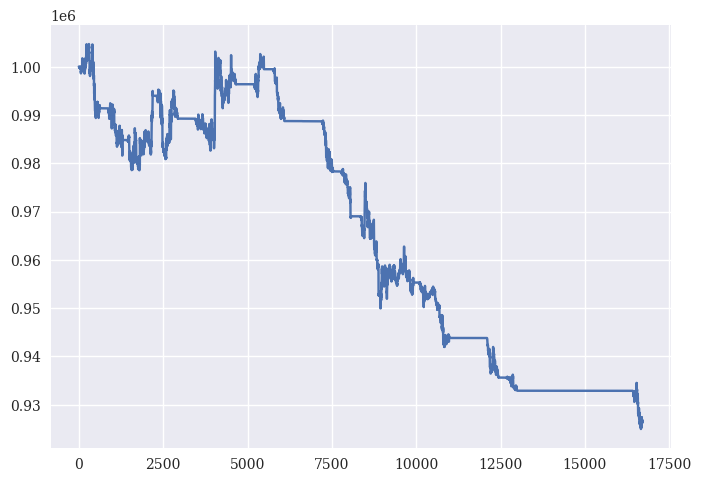

In [150]:
%matplotlib inline
df_account_value.account_value.plot()

In [151]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.00115
Cumulative returns    -0.07340
Annual volatility      0.00450
Sharpe ratio          -0.25309
Calmar ratio          -0.01449
Stability              0.86456
Max drawdown          -0.07933
Omega ratio            0.92795
Sortino ratio         -0.36176
Skew                       NaN
Kurtosis                   NaN
Tail ratio             0.95410
Daily value at risk   -0.00057
dtype: float64


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="True", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

In [ ]:
import backtest as bt

env = test_env
bt.backtest(agent, env)
env.data['p'].iloc[env.lags:].value_counts()
sum(env.data['p'].iloc[env.lags:].diff() != 0)

(env.data[['r', 's']].iloc[env.lags:] * env.leverage).sum(
        ).apply(np.exp)

(env.data[['r', 's']].iloc[env.lags:] * env.leverage).sum(
        ).apply(np.exp) - 1

(env.data[['r', 's']].iloc[env.lags:] * env.leverage).cumsum(
        ).apply(np.exp).plot(figsize=(10, 6))

In [ ]:
import tpqoa
import pickle
import numpy as np
import pandas as pd
import talib as ta

class MLTrader(tpqoa.tpqoa):
    def __init__(self, config_file, algorithm):
        super(MLTrader, self).__init__(config_file)
        self.model = algorithm['model'] 
        self.mu = algorithm['mu'] 
        self.std = algorithm['std'] 
        self.units = 100000 
        self.position = 0 
        self.bar = '5s' 
        self.window = 2 
        self.lags = 10 
        self.min_length = self.lags + self.window + 63
        #self.features = algorithm['cols'] 
        self.raw_data = pd.DataFrame()        
    def report_trade(self, pos, order):
        out = '\n\n' + 80 * '=' + '\n'
        out += '*** GOING {} *** \n'.format(pos) + '\n'
        out += str(order) + '\n'
        out += 80 * '=' + '\n'
        print(out)
    def prepare_features(self): 
        # MOMENTUM
        self.data['ADX'] = ta.ADX(self.data.high.values, self.data.low.values,self.data.close.values)  
        self.data['ADXR'] = ta.ADXR(self.data.high.values, self.data.low.values,self.data.close.values)
        self.data['APO'] = ta.APO(self.data.close.values) 
        self.data['AROONdown'],self.data['AROONup'] = ta.AROON(self.data.high.values, self.data.low.values)
        self.data['AROONdmu'] = self.data['AROONdown'] - self.data['AROONup']        
        self.data['AROONOSC'] = ta.AROONOSC(self.data.high.values, self.data.low.values)        
        self.data['BOP'] = ta.BOP(self.data.open.values,self.data.high.values, self.data.low.values,self.data.close.values)     
        self.data['CCI'] = ta.CCI(self.data.high.values, self.data.low.values,self.data.close.values)          
        self.data['CMO'] = ta.CMO(self.data.close.values) 
        self.data['DX'] = ta.DX(self.data.high.values, self.data.low.values,self.data.close.values)     
        self.data['macd'],self.data['macdsignal'],self.data['macdhist'] = ta.MACD(self.data.close.values)       
        self.data['macdFIX'],self.data['macdsignalFIX'],self.data['macdhistFIX'] = ta.MACDFIX(self.data.close.values)   
        self.data['MINUS_DI'] = ta.MINUS_DI(self.data.high.values, self.data.low.values,self.data.close.values)
        self.data['MINUS_DM'] = ta.MINUS_DM(self.data.high.values, self.data.low.values) 
        self.data['MOM'] = ta.MOM(self.data.close.values) 
        self.data['PLUS_DI'] = ta.PLUS_DI(self.data.high.values, self.data.low.values,self.data.close.values)
        self.data['PLUS_DM'] = ta.PLUS_DM(self.data.high.values, self.data.low.values)   
        self.data['PPO'] = ta.PPO(self.data.close.values) 
        self.data['ROC'] = ta.ROC(self.data.close.values) 
        self.data['ROCP'] = ta.ROCP(self.data.close.values) 
        self.data['ROCR100'] = ta.ROCR100(self.data.close.values) 
        self.data['RSI'] = ta.RSI(self.data.close.values,14) 
        self.data['slk'],self.data['sld'] = ta.STOCH(self.data.high.values, self.data.low.values,self.data.close.values)
        self.data['STOCHkmdSl'] = self.data['slk'] - self.data['sld'] 
        self.data['fastk'],self.data['fastd'] = ta.STOCHF(self.data.high.values, self.data.low.values,self.data.close.values)
        self.data['STOCHkmdFast'] = self.data['fastk'] - self.data['fastd']       
        self.data['slkRSI'],self.data['sldRSI'] = ta.STOCHRSI(self.data.close.values)
        self.data['STOCKkmdRSI'] = self.data['slkRSI'] - self.data['sldRSI']        
        self.data['TRIX'] = ta.TRIX(self.data.close.values)
        self.data['ULTOSC'] = ta.ULTOSC(self.data.high.values, self.data.low.values,self.data.close.values)   
        self.data['WILLR'] = ta.WILLR(self.data.high.values, self.data.low.values,self.data.close.values)           
               

        #VOLATILITY
        self.data['ATR63'] = ta.ATR(self.data.high.values, self.data.low.values,self.data.close.values,63)     
        self.data['ATR'] = ta.ATR(self.data.high.values, self.data.low.values,self.data.close.values)  
        self.data['NATR'] = ta.NATR(self.data.high.values, self.data.low.values,self.data.close.values)         
        
        # CYCLES
        self.data['HT_DCPERIOD'] = ta.HT_DCPERIOD(self.data.close.values) 
        self.data['HT_DCPHASE'] = ta.HT_DCPHASE(self.data.close.values)
        self.data['inphase'],self.data['quadrature'] = ta.HT_PHASOR(self.data.close.values)
        self.data['sine'],self.data['leadsine'] = ta.HT_SINE(self.data.close.values)
        self.data['sls'] = self.data['sine'] - self.data['leadsine']
        self.data['HT_TRENDMODE'] = ta.HT_TRENDMODE(self.data.close.values) 
        
        # PRICE-ACTION
        self.data['C/O'] = self.data.close / self.data.open -1
        self.data['H/L'] = self.data.high / self.data.low -1
        self.data['C/L'] = self.data.close / self.data.low -1
        self.data['H/Lt'] = self.data.high / self.data.low.shift() -1
        self.data['L/Lt'] = self.data.low / self.data.low.shift() -1
        self.data['H/Ht2'] = self.data.high / self.data.high.shift(2) -1
        self.data['H/Lt3'] = self.data.high / self.data.low.shift(3) -1
        self.data['L/Lt'] = self.data.low / self.data.low.shift() -1
        self.data['C/Ct2'] = self.data.close / self.data.close.shift(2) -1
        self.data['C/Ct3'] = self.data.close / self.data.close.shift(3) -1
        
        self.data['returns'] = np.log(self.data['close'] / self.data['close'] .shift())
        self.data['direction'] = np.where(self.data['returns'] > 0, 1, 0)
        
        self.data.dropna(inplace=True)
        
        self.cols = []
        self.features = self.data.drop(['open', 'high', 'low', 'close'], axis=1).columns.tolist()
        for f in self.features:
            for lag in range(1, self.lags + 1):
                col = f'{f}_lag_{lag}'
                self.data[col] = self.data[f].shift(lag)
                self.cols.append(col)
        
        # normalize data
        self.data[self.features] -= self.mu
        self.data[self.features] /= self.std
        

    def on_success(self, time, bid, ask):
        print(self.ticks, 20 * ' ', end='\r')
        df = pd.DataFrame({'bid': float(bid), 'ask': float(ask)},
        index=[pd.Timestamp(time).tz_localize(None)])
        self.raw_data = self.raw_data.append(df)
        self.data = self.raw_data.resample(
        self.bar, label='right').last().ffill()
        self.data = self.data.iloc[:-1]
        if len(self.data) > self.min_length:
            self.min_length += 1
            self.data['close'] = (self.data['bid'] + self.data['ask']) / 2
            self.data = self.data['close'].resample('10S').ohlc()
            self.prepare_features()
            features = self.data[self.cols].iloc[-1:,:].values.reshape(1, -1)
            signal = self.model.predict(features)[0]
    
            if self.position in [0, -1] and signal == 1: # going long?
                order = self.create_order(self.stream_instrument,
                units=(1 - self.position) *
                self.units,
                uppress=True, ret=True)
                self.report_trade('LONG', order)
                self.position = 1
            elif self.position in [0, 1] and signal == -1: # going short?
                order = self.create_order(self.stream_instrument,
                units=-(1 + self.position) *
                self.units,
                suppress=True, ret=True)
                self.report_trade('SHORT', order)
                self.position = -1

# load persisted model
algo = pickle.load(open('algorithm.pkl', 'rb'))

if __name__ == '__main__':
    # instantiate class
    mlt = MLTrader('ONDdemo.cfg', algo) 
    mlt.stream_data('EUR_USD') # stop=10000
    order = mlt.create_order(mlt.stream_instrument,
    units=-mlt.position * mlt.units,
    suppress=True, ret=True)
    mlt.position = 0
    mlt.report_trade('NEUTRAL', order)